# **Download from Drive**

---



In [2]:
!gdown --id '1W9Nfeud6VPLL4N90mHGsNuZK2ECwlWo8'


Downloading...
From: https://drive.google.com/uc?id=1W9Nfeud6VPLL4N90mHGsNuZK2ECwlWo8
To: /content/verification_train.csv
133MB [00:02, 54.8MB/s]


In [7]:
!gdown --id '1FNRsmAjjwvbBIQPhktGst0fn9uWw0DQK'



Downloading...
From: https://drive.google.com/uc?id=1FNRsmAjjwvbBIQPhktGst0fn9uWw0DQK
To: /content/verification_test.csv
22.2MB [00:00, 36.0MB/s]


# **Imports**

---



In [4]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train_df = pd.read_csv('verification_train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 60000
Number of training pixels: 784
Number of classes: 10


In [8]:
test_df = pd.read_csv('verification_test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)-1
n_class = len(set(train_df['label']))

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of train samples: 10000
Number of test pixels: 784
Number of classes: 10


# **Data Visualization**

---



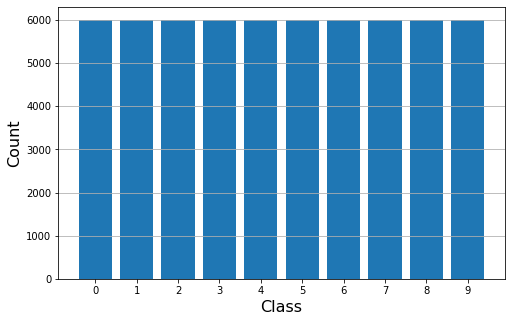

In [9]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

7, 8, 5, 4, 8, 3, 0, 8


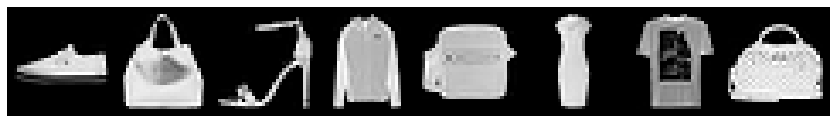

In [10]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

# **Data Preprocessing**

---



In [11]:
class processDataset(Dataset):
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path)
        
        # training data
        self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
        self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.transform(self.X[idx]), self.y[idx]

In [12]:
train_dataset = processDataset('verification_train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = processDataset('verification_test.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.5,), std=(0.5,))]))

In [13]:
print(len(train_dataset), len(test_dataset))

60000 10000


# **EXP_03_model_1**

---



In [16]:
# Hyperparameters
batch_size = 20
num_iters = 20000
input_dim = 28*28
output_dim = 10
learning_rate = 0.01

In [17]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear_1 = nn.Linear(input_size,79)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(79, 40)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(40, 30)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(30, 22)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(22, 16)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(16, 13)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(13, num_classes)

    def forward(self, x):
        
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
test_loss_min = 9999999
iter_data,train_loss_data, test_loss_data, acc_data = [], [], [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            train_loss = train_loss / len(train_loader.dataset)
            test_loss = test_loss / len(test_loader.dataset)
            train_loss_data.append(train_loss)
            test_loss_data.append(test_loss)
            accuracy = 100 * correct.item() / total
            acc_data.append(accuracy)
            iter_data.append(iter)

            # Print Loss
            print('Iteration: {}. Train_Loss: {}. Valid_Loss: {}. Accuracy: {}'.format(iter, train_loss, test_loss, accuracy))

            if test_loss <= test_loss_min:
              print('***Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...***'.format(test_loss_min,test_loss))
              torch.save(model.state_dict(), 'EXP_02_trial_2.pt')
              test_loss_min = test_loss

Iteration: 500. Train_Loss: 0.38524372029304504. Valid_Loss: 2.3058805994987486. Accuracy: 10.0
***Validation loss decreased (9999999.000000 --> 2.305881). Saving model ...***
Iteration: 1000. Train_Loss: 0.3840729334723036. Valid_Loss: 2.3034375487380503. Accuracy: 9.99
***Validation loss decreased (2.305881 --> 2.303438). Saving model ...***
Iteration: 1500. Train_Loss: 0.38373946467495423. Valid_Loss: 2.30243543093978. Accuracy: 10.85
***Validation loss decreased (2.303438 --> 2.302435). Saving model ...***
Iteration: 2000. Train_Loss: 0.3836783132551974. Valid_Loss: 2.301385614732211. Accuracy: 10.01
***Validation loss decreased (2.302435 --> 2.301386). Saving model ...***
Iteration: 2500. Train_Loss: 0.38346262845788004. Valid_Loss: 2.3002562711450913. Accuracy: 10.0
***Validation loss decreased (2.301386 --> 2.300256). Saving model ...***
Iteration: 3000. Train_Loss: 0.38320259189143335. Valid_Loss: 2.297642847396829. Accuracy: 13.81
***Validation loss decreased (2.300256 --> 2.2

## **Loss Graph**

---



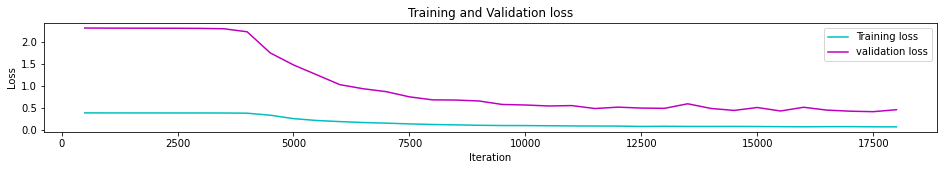

In [18]:
import matplotlib.pyplot as plt
plt.plot(iter_data, train_loss_data, 'c', label='Training loss')
plt.plot(iter_data, test_loss_data, 'm', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Accuracy Graph**

---



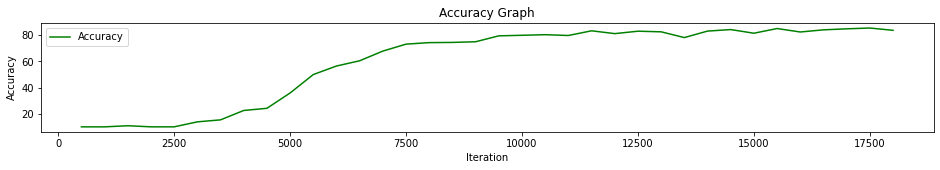

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(iter_data, acc_data, 'g', label='Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **EXP_03_model_2**

---



In [22]:
# Hyperparameters
batch_size = 64
num_iters = 70000
input_dim = 28*28
output_dim = 10
learning_rate = 0.05

In [23]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 512)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(512,128)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(128,32)
        self.relu_3 = nn.ReLU()


        self.linear_out = nn.Linear(32, num_classes)
        self.relu_out = nn.ReLU()

    def forward(self, x):
        
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)
        
        
        probas  = self.linear_out(out)
        probas  = self.relu_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
test_loss_min = 9999999
iter_data,train_loss_data, test_loss_data, acc_data = [], [], [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            train_loss = train_loss / len(train_loader.dataset)
            test_loss = test_loss / len(test_loader.dataset)
            train_loss_data.append(train_loss)
            test_loss_data.append(test_loss)
            accuracy = 100 * correct.item() / total
            acc_data.append(accuracy)
            iter_data.append(iter)

            # Print Loss
            print('Iteration: {}. Train_Loss: {}. Valid_Loss: {}. Accuracy: {}'.format(iter, train_loss, test_loss, accuracy))

            if test_loss <= test_loss_min:
              print('***Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...***'.format(test_loss_min,test_loss))
              torch.save(model.state_dict(), 'EXP_02_trial_2.pt')
              test_loss_min = test_loss

Iteration: 500. Train_Loss: 0.5902462930997213. Valid_Loss: 0.8723572267532349. Accuracy: 75.48
***Validation loss decreased (9999999.000000 --> 0.872357). Saving model ...***
Iteration: 1000. Train_Loss: 0.03237736307779948. Valid_Loss: 0.4702292806148529. Accuracy: 83.88
***Validation loss decreased (0.872357 --> 0.470229). Saving model ...***
Iteration: 1500. Train_Loss: 0.23752473427654688. Valid_Loss: 0.4157781936300421. Accuracy: 85.29
***Validation loss decreased (0.470229 --> 0.415778). Saving model ...***
Iteration: 2000. Train_Loss: 0.05197859843571981. Valid_Loss: 0.4868652464866638. Accuracy: 81.71
Iteration: 2500. Train_Loss: 0.20551719907142058. Valid_Loss: 0.38089834320189475. Accuracy: 86.21
***Validation loss decreased (0.415778 --> 0.380898). Saving model ...***
Iteration: 3000. Train_Loss: 0.0692688667456309. Valid_Loss: 0.36880976424217227. Accuracy: 86.74
***Validation loss decreased (0.380898 --> 0.368810). Saving model ...***
Iteration: 3500. Train_Loss: 0.188709

## **Loss Graph**

---



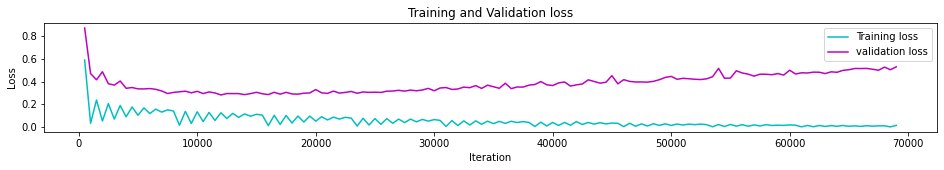

In [24]:
import matplotlib.pyplot as plt
plt.plot(iter_data, train_loss_data, 'c', label='Training loss')
plt.plot(iter_data, test_loss_data, 'm', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Accuracy Graph**

---



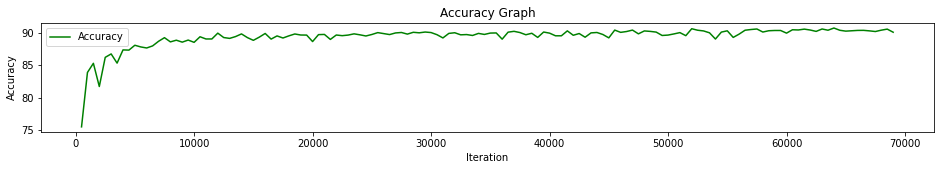

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(iter_data, acc_data, 'g', label='Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()